In [43]:
%matplotlib widget
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import gensim.downloader as api
import numpy as np
import re
from tqdm import tqdm

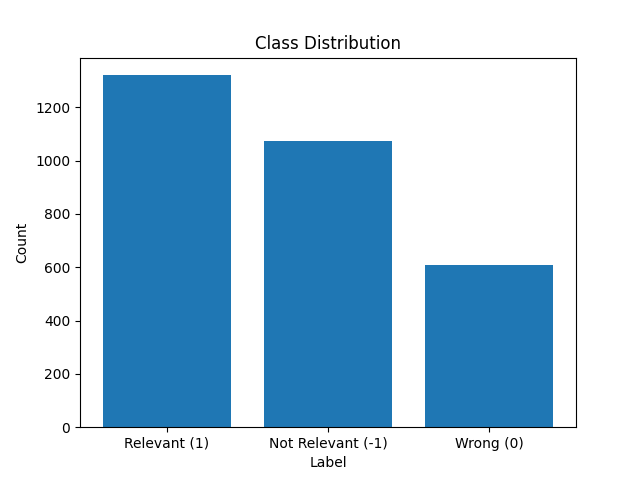

In [44]:
# Read the first Excel file
df1 = pd.read_excel('./Data/apple_tweets_devin_labeled.xlsx')

# Read the second Excel file
df2 = pd.read_excel('./Data/apple_tweets_hemanth_labeled.xlsx')

df3 = pd.read_excel('./Data/apple_tweets_nico_labeled.xlsx')

# Merge the two dataframes
df = pd.concat([df1, df2, df3], ignore_index=True)

# Make all Label = 0 to Label = -1 if not removing the @mentions
# df.loc[df['Label'] == 0, 'Label'] = -1

# Visualize the class distributions
class_counts = df['Label'].value_counts()
class_labels = ['Relevant (1)', 'Not Relevant (-1)', 'Wrong (0)']
# class_labels = ['Not Relevant', 'Relevant']
plt.figure()
plt.bar(class_labels, class_counts)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()


In [45]:
# Write the combined data to CSV if needed
# df.to_csv('combined_data_apple.csv', encoding='utf-8', index=False)

In [46]:
df['Text'] = df['Text'].fillna('').astype(str)

def append_keyword(row):
    # keyword = row['keyword'] + ": "
    keyword = "1: "
    text = row['Text']
    return keyword + text

df["Text"] = df.apply(append_keyword, axis=1)


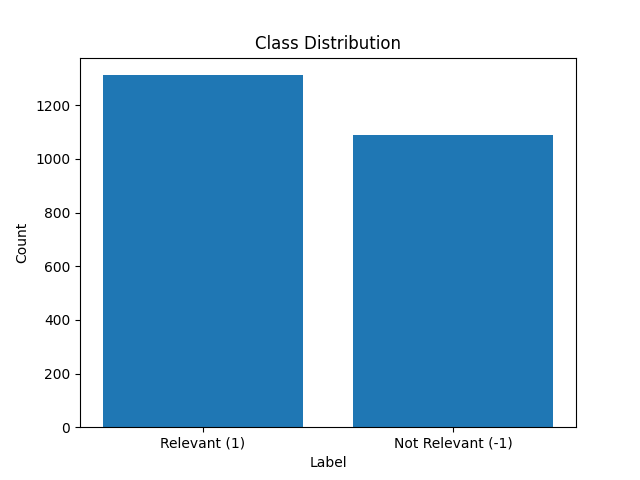

In [47]:
df['Text'] = df['Text'].fillna('').astype(str)
# df['keyword'] = df['keyword'].fillna('').astype(str)

# Step 2: Define a function to check keyword occurrences
def check_keyword_occurrences(row):
    # keyword = row['keyword']
    keyword = 'apple'
    text = row['Text']
    # Create a regex pattern to find isolated occurrences of the keyword
    pattern = fr'\b{keyword}\b'  # '\b' is a word boundary in regex
    
    # Find all occurrences of the keyword
    all_occurrences = re.findall(pattern, text, flags=re.IGNORECASE)
    
    # Find all occurrences that are part of other strings like @mentions
    mention_occurrences = re.findall(fr'@\w*{keyword}\w*', text, flags=re.IGNORECASE)
    
    # Check if there are no isolated occurrences of the keyword
    # and at least one mention-like occurrence
    if len(all_occurrences) == 0 and len(mention_occurrences) > 0:
        return False  # Remove this row because keyword only appears in mentions
    return True  # Keep this row because keyword appears isolated or not in mentions at all


# Step 3: Filter the DataFrame
filtered_df = df[df.apply(check_keyword_occurrences, axis=1)]

# Step 4: Save the processed DataFrame
# filtered_df.to_csv('processed_file_apple.csv', index=False)

# Make 0s as -1
filtered_df.loc[filtered_df['Label'] == 0, 'Label'] = -1

class_counts = filtered_df['Label'].value_counts()
class_labels = ['Relevant (1)', 'Not Relevant (-1)']
# class_labels = ['Not Relevant', 'Relevant']
plt.figure()
plt.bar(class_labels, class_counts)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

In [48]:
# Comment this to run without @mention filtering.
df = filtered_df
# Load pre-trained word embeddings (word2vec)
word_vectors = api.load("word2vec-google-news-300")

In [55]:
# Feature extraction and SVC


def extract_features(text):
    if isinstance(text, str):
        tokens = text.lower().split()  # Tokenize and convert to lowercase
        word_embeddings = [word_vectors[token] for token in tokens if token in word_vectors]  # Get word embeddings
        return sum(word_embeddings) if word_embeddings else None  # Sum of word embeddings
    else:
        return None  # Return None for non-string inputs

df['Features'] = df['Text'].apply(extract_features)

# Remove rows with missing features
df = df.dropna()
df.loc[df['Label'] == 0, 'Label'] = -1

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['Features'].tolist(), df['Label'], test_size=0.2)#, random_state=42)

# Train a Support Vector Classifier (SVC)
clf = SVC(kernel='linear')
clf.fit(X_train, y_train)

# Predictions
y_pred = clf.predict(X_test)

# Evaluation
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

          -1       0.84      0.90      0.87       364
           1       0.87      0.81      0.84       316

    accuracy                           0.85       680
   macro avg       0.86      0.85      0.85       680
weighted avg       0.86      0.85      0.85       680



# Attempt at combined classification

In [72]:
def extract_balanced_sample(df, num_samples=500):
    positive_samples = df[df['Label'] == 1]
    negative_samples = df[df['Label'] == -1]

    positive_samples = positive_samples.sample(min(len(positive_samples), num_samples//2), random_state=42)
    negative_samples = negative_samples.sample(min(len(negative_samples), num_samples//2), random_state=42)

    # Concatenate the sampled positive and negative samples
    balanced_df = pd.concat([positive_samples, negative_samples])

    # Shuffle the DataFrame
    balanced_df = balanced_df.sample(frac=1)#, random_state=42)
    return balanced_df


In [73]:
df1 = pd.read_excel('./Data/apple_tweets_devin_labeled.xlsx')
df2 = pd.read_excel('./Data/apple_tweets_hemanth_labeled.xlsx')
df3 = pd.read_excel('./Data/apple_tweets_nico_labeled.xlsx')

# Assign random -1/+1
df4 = pd.read_excel('./Data/filtered_tweets_dove_sprint_spirit_delta.xlsx')
df4 = extract_balanced_sample(df4, num_samples=500)

df = pd.concat([df1, df2, df3], ignore_index=True)

df['Text'] = df['Text'].fillna('').astype(str)
df = df[df.apply(check_keyword_occurrences, axis=1)]

df["Keyword"] = "Apple"
df = pd.concat([df, df4], ignore_index=True)


# List of compaanies you want to perform classification on
entities = ['Apple', 'dove', 'sprint', 'spirit', 'delta']

# Select only the rows with the specified companies in the 'Keyword' column
df = df[df['Keyword'].isin(entities)]
df = df[df['Label'] != 0]
df

,Label,Text,Keyword
0,1,They really have delayed it? http://www.apple....,Apple
1,1,breaking news... the 3.0 update will be availa...,Apple
2,1,"So, #Apple are releasing #iPhone #3.0 software...",Apple
3,1,@pollyesther att.probably not...but Apple gave...,Apple
4,-1,didn't do his apple diet and has been living ...,Apple
...,...,...,...
2892,1,hey all! i know its been a min. got the new sp...,sprint
2893,-1,Im on sprint hway..on my way back home yeay!,sprint
2894,1,hmmm saw this thing on a commericial for sprin...,sprint
2895,-1,"hope to participate in mapnik sprint, need to ...",sprint


In [74]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import gensim.downloader as api

# Load pre-trained word embeddings (word2vec)
# word_vectors = api.load("word2vec-google-news-300")

In [77]:
def extract_features(row):
    # Extract keyword and text
    keyword = row['Keyword']
    text = row['Text']

    # Embeddings for keyword
    keyword_embedding = word_vectors[keyword] if keyword in word_vectors else np.zeros(300)

    # Embeddings for text
    tokens = text.lower().split()
    text_embeddings = [word_vectors[token] for token in tokens if token in word_vectors]
    text_embedding_sum = sum(text_embeddings) if text_embeddings else np.zeros(300) 

    # Combine embeddings by averaging or summing
    combined_embedding = (keyword_embedding + text_embedding_sum) / (len(text_embeddings) + 1 if text_embeddings else 1)

    return combined_embedding


# Ensure string type and handle missing data
df['Keyword'] = df['Keyword'].fillna('').astype(str)
df['Text'] = df['Text'].fillna('').astype(str)
df.loc[df['Label'] == 0, 'Label'] = -1

# Apply feature extraction
df['Features'] = df.apply(extract_features, axis=1)

# Remove rows with missing features if any (none should be missing with the current setup)
df = df.dropna(subset=['Features'])

# Split data
X_train, X_test, y_train, y_test = train_test_split(df['Features'].tolist(), df['Label'], test_size=0.2)#, random_state=42)

# Train classifier
clf = SVC(kernel='linear')
clf.fit(list(X_train), y_train)

# Predictions
y_pred = clf.predict(list(X_test))

# Evaluation
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

          -1       0.92      0.84      0.88       264
           1       0.87      0.94      0.90       310

    accuracy                           0.89       574
   macro avg       0.90      0.89      0.89       574
weighted avg       0.89      0.89      0.89       574



# Trying to visualize

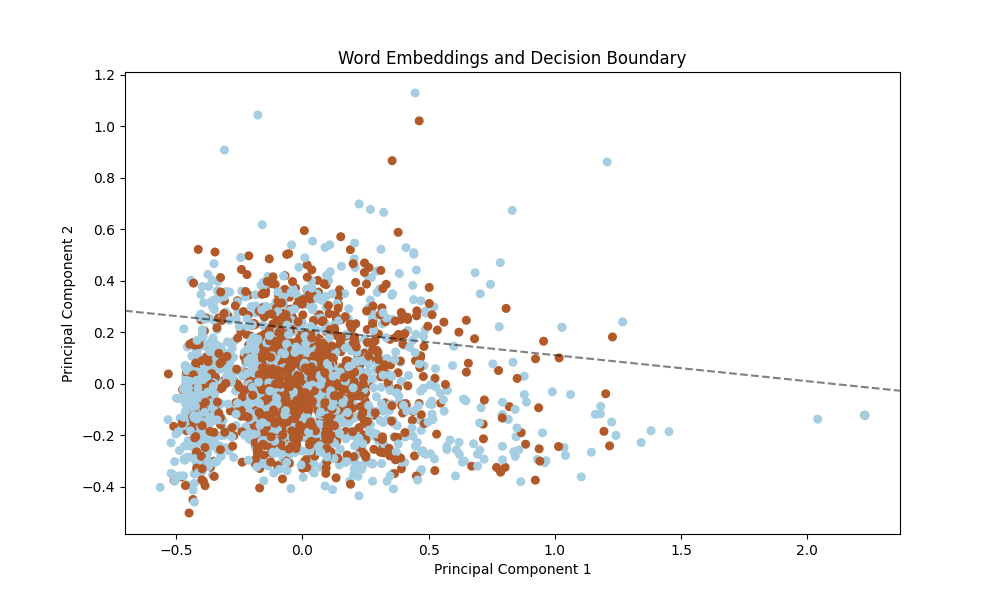

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.svm import SVC

# Assuming word_vectors, X_train, y_train are defined as in the previous code snippet

# Perform PCA for dimensionality reduction
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)

# Train a Support Vector Classifier (SVC) with linear kernel
clf = SVC(kernel='linear')
clf.fit(X_train_pca, y_train)

# Visualize word embeddings and decision boundaries
def plot_embedding_and_decision_boundary(X, y, clf, pca):
    # Plot word embeddings
    plt.figure(figsize=(10, 6))
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, s=30)

    # Plot decision boundary
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # Create grid to evaluate model
    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 50),
                         np.linspace(ylim[0], ylim[1], 50))
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])

    # Plot decision boundary and margins
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
                linestyles=['--', '-', '--'])

    plt.title('Word Embeddings and Decision Boundary')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()

plot_embedding_and_decision_boundary(X_train_pca, y_train, clf, pca)


# LLM test

### The next block of code is just a repeat of reading the data files. 
- Need to figure out a way to just use test data.


In [24]:
df1 = pd.read_excel('./Data/apple_tweets_devin_labeled.xlsx')
df2 = pd.read_excel('./Data/apple_tweets_hemanth_labeled.xlsx')
df3 = pd.read_excel('./Data/apple_tweets_nico_labeled.xlsx')

# Assign random -1/+1
df4 = pd.read_excel('./Data/filtered_tweets_dove_sprint_spirit_delta.xlsx')

df = pd.concat([df1, df2, df3], ignore_index=True)

df['Text'] = df['Text'].fillna('').astype(str)
df = df[df.apply(check_keyword_occurrences, axis=1)]

df["Keyword"] = "Apple"
df = pd.concat([df, df4], ignore_index=True)


# List of compaanies you want to perform classification on
entities = ['Apple', 'dove', 'sprint', 'spirit', 'delta']

# Select only the rows with the specified companies in the 'Keyword' column
df = df[df['Keyword'].isin(entities)]
df = df[df['Label'] != 0]

In [40]:
import openai
OPEN_API_KEY = "key-here"

# keyword = 'Apple'
# input_string = """Leaving Northpoint's C3G mtg. headed to Crabapple Middle. out of the tornado shelter safely.""" 
# prompt = f"""The below, in quotes, is a tweet containing the substring "{keyword}".
# It was automatically extracted and needs to be classified into one of the two classes. The classes are 1: PERTINENT TO Apple, Inc., the technology company,
# or -1: NOT PERTINENT TO Apple, Inc. In your response, output simply -1 or 1, with the correct class.
# Test string below:

# '{input_string}'"""

openai.api_key = OPEN_API_KEY
model_id = 'gpt-3.5-turbo'

client = openai.OpenAI(api_key = OPEN_API_KEY)

def get_model_response(text, keyword):
    prompt = f"""The below, in quotes, is a tweet containing the substring "{keyword}".
                It was automatically extracted and needs to be classified into one of the two classes. The classes are 1: PERTINENT TO Apple, Inc., the technology company,
                or -1: NOT PERTINENT TO Apple, Inc. In your response, output simply -1 or 1, with the correct class.
                Test string below:

                '{text}'"""

    response = client.chat.completions.create(
        model=model_id,
        messages=[{'role': 'user', 'content': prompt}]
    )
    output = response.choices[0].message.content

    try:
        output_int = int(output)
        conversion_error = None
    except ValueError:
        output_int = 0
        conversion_error = f"Conversion error for Keyword: {keyword}, Text: {text}"
 
    return output_int, conversion_error

In [42]:
# Iterate through each row of the DataFrame and call the function
error_count = 0
conversion_errors = []
count = 0
for index, row in tqdm(df.iterrows()):
    count+=1
    if count % 10 == 0:
        df.to_csv('Data/LLM_result.csv', index=False)
    if count < 65:
        continue
    keyword = row['Keyword']
    text = row['Text']
    label = row['Label']
    
    # Call the function with Keyword, Text, and Label as inputs
    output_int, conversion_error = get_model_response(keyword, text)
    
    # Handle conversion errors
    if conversion_error:
        conversion_errors.append(conversion_error)
        error_count += 1
    
    # Do something with the output_int, such as storing it in a new column of the DataFrame
    # For example:
    df.at[index, 'LLM_pred'] = output_int

# Print conversion errors
if conversion_errors:
    print("Conversion errors:")
    for error in conversion_errors:
        print(error)

print(f"Total errors encountered: {error_count}")


64it [00:03, 17.12it/s]


RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-3.5-turbo in organization org-w4nQzRc0cFoiacNHwNMATvs6 on requests per day (RPD): Limit 200, Used 200, Requested 1. Please try again in 7m12s. Visit https://platform.openai.com/account/rate-limits to learn more. You can increase your rate limit by adding a payment method to your account at https://platform.openai.com/account/billing.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}}